#Improving the accuracy of Random Forest Models

Random forest is a powerful and robust algorithm, which is a combination of many individual decision trees. However, a significant concern arises when utilizing random forests: we often generate more foundational decision trees than necessary.

While we can adjust this through hyperparameter tuning, it demands training a multitude of random forest models, consuming considerable time.

The below method will show you how to enhance the precision of a random forest model without having to retrain the model multiple times for hyperparameter tuning.

In [2]:
import seaborn as sns
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

sns.set()

## Theory:


Random forest is an ensemble of many individual decision trees. Each decision tree in a random forest is independent. The final prediction is generated by aggregating the predictions from each individual and independent decision tree (some underperforming and some well-performing decision trees)

Steps:
1. Find the test accuracy of every decision tree.
2. Sort the accuracies in decreasing order.
3. Keep only the “k” top-performing decision trees and drop the rest.
4. To decide “k”, create a cumulative accuracy plot.
5. The accuracy will first increase with the number of decision trees and then decrease. This can help find the most optimal value of “k”.


## Step 1 - Create dataset

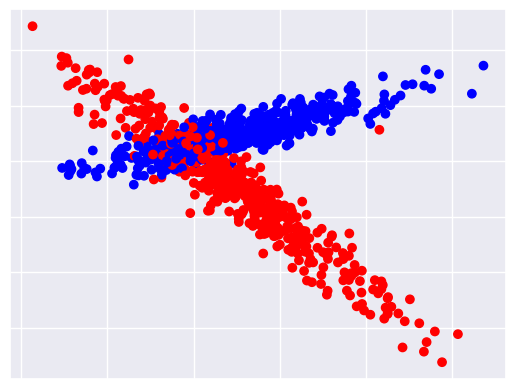

In [36]:
# Generate some synthetic data to train the decision tree on
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_clusters_per_class=1,
    n_informative=2,
    class_sep=0.5,
    n_redundant=0,
    n_repeated=0
)

# Define colors for the classes
colors = np.array(['red', 'blue', 'green'])

fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=colors[y])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()


## Step 2 - Train a Random Forest Model

In [17]:
#Split data in train and test
X_train, X_test = X[:800], X[800:]
y_train, y_test = y[:800], y[800:]

In [18]:
model = RandomForestClassifier(max_features="sqrt", max_samples=0.9, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.9, random_state=42)

In [19]:
model.score(X_test, y_test)

0.825

## Step 3 - Compute the accuracy of each decision tree model

In [26]:
#The model_score is a NumPy array that stores tree id and its test accuracy:

model_score = [] # list to store accuracies

for idx, tree in enumerate(model.estimators_):

    score = tree.score(X_test, y_test) # find accuracy
    model_score.append([idx, score]) # store accuracy

model_score = np.array(model_score)

In [27]:
model_score

array([[ 0.   ,  0.81 ],
       [ 1.   ,  0.77 ],
       [ 2.   ,  0.73 ],
       [ 3.   ,  0.78 ],
       [ 4.   ,  0.79 ],
       [ 5.   ,  0.78 ],
       [ 6.   ,  0.745],
       [ 7.   ,  0.78 ],
       [ 8.   ,  0.78 ],
       [ 9.   ,  0.775],
       [10.   ,  0.825],
       [11.   ,  0.795],
       [12.   ,  0.745],
       [13.   ,  0.785],
       [14.   ,  0.745],
       [15.   ,  0.77 ],
       [16.   ,  0.78 ],
       [17.   ,  0.77 ],
       [18.   ,  0.765],
       [19.   ,  0.79 ],
       [20.   ,  0.74 ],
       [21.   ,  0.82 ],
       [22.   ,  0.79 ],
       [23.   ,  0.77 ],
       [24.   ,  0.76 ],
       [25.   ,  0.775],
       [26.   ,  0.79 ],
       [27.   ,  0.785],
       [28.   ,  0.81 ],
       [29.   ,  0.73 ],
       [30.   ,  0.75 ],
       [31.   ,  0.78 ],
       [32.   ,  0.79 ],
       [33.   ,  0.78 ],
       [34.   ,  0.79 ],
       [35.   ,  0.78 ],
       [36.   ,  0.77 ],
       [37.   ,  0.83 ],
       [38.   ,  0.75 ],
       [39.   ,  0.85 ],


## Step 4 - Sort the list by accuracy

In [28]:
sorted_indices = np.argsort(model_score[:, 1])[::-1]

# Rearrange the rows of the array based on the sorted indices
model_ids = model_score[sorted_indices][:,0].astype(int)

In [31]:
model_ids

array([39, 37, 10, 69, 95, 86, 76, 21, 55,  0, 40, 28, 63, 92, 94, 48, 41,
       77, 60, 67, 73, 71, 78, 11, 87, 65, 45, 97,  4, 34, 32, 90, 26, 43,
       22, 75, 19, 82, 91, 27, 57, 13, 47, 64, 44,  7,  3, 16, 88, 35,  8,
       33, 31,  5, 79,  9, 25, 99, 83, 56, 80, 68, 89, 84, 15, 17, 23, 58,
       62,  1, 51, 36, 50, 54, 61, 96, 18, 24, 81, 46, 49, 93, 98, 38, 30,
       52, 14, 12, 72,  6, 85, 20, 66, 53, 74, 70, 29,  2, 42, 59])

Tree 39 has the highest accuracy foolowed by tree 37, etc.

In [29]:
# create numpy array, rearrange the models and convert back to list
model.estimators_ = np.array(model.estimators_)[model_ids].tolist()

Let's compute cummulative accuracy and create a plot to find the optimal 'k'

In [32]:
result = []

#This line retrieves the total number of decision trees (or base estimators) in the model,
total_models = len(model.estimators_)

#Since we are computing cumulative accuracy, this loop iterates from the third model (index 2) up to the last model in the ensemble.
for i in range(2, total_models):

    #create a deep copy of the model, ensuring that changes made to small_model won't affect the original model.
    small_model = copy.deepcopy(model)

    #This line modifies the small_model to keep only the first i decision trees from the original model.
    small_model.estimators_ = model.estimators_[:i]

    #The score method evaluates the performance of small_model on the test data (X_test, y_test).
    #The number of decision trees (i.e., i) and the performance score are then appended to the result list as a pair.
    result.append([i, small_model.score(X_test, y_test)])

result = np.array(result)

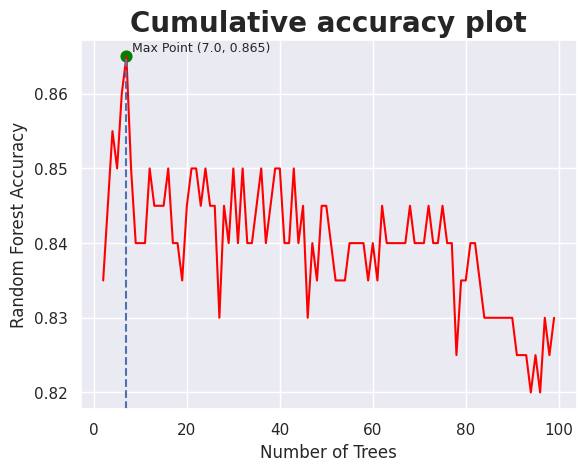

In [51]:
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], c = colors[0])
ax.axvline(x=result[max_index][0], ymax=0.95, ls = "--")
plt.scatter([result[max_index][0],], [result[max_index][1],], zorder=0, s=60, c = colors[2])

ax.set_title("Cumulative accuracy plot", fontsize = 20, fontweight = "bold")

# Set x and y axis titles
ax.set_xlabel("Number of Trees")
ax.set_ylabel("Random Forest Accuracy")

# Add a label for the maximum index point
ax.annotate(f'Max Point ({result[max_index][0]}, {result[max_index][1]:.3f})',
            xy=(result[max_index][0], result[max_index][1]),
            xytext=(4,4),  # specify the position (in points) where the label should appear relative to the point
            textcoords='offset points',
            fontsize=9)

plt.show()

Observation:

Keeping all the 100 individual trees and aggregating the accuracy gives us 82.5% accuracy. However, with this method, only the first best 7 individual trees gives us 86% accuracy. A boost of 3.5%

## Create final model

In [53]:
small_model = copy.deepcopy(model)

small_model.estimators_ = model.estimators_[:int(result[max_index][0])]

In [57]:
small_model

RandomForestClassifier(max_samples=0.9, random_state=42)

In [54]:
#Model accuracy with 7 best decision trees
small_model.score(X_test, y_test)

0.865

In [55]:
#Model accuracy with 100 decision trees
model.score(X_test, y_test)

0.825

In [58]:
#Runtime with 100 decision trees
%timeit model.predict(X_test)

9.55 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
#Runtime with 7 decision trees
%timeit small_model.predict(X_test)

1.04 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Conclusion**:
* We get a 3% accuracy boost.
* faster run-time.

Thank you